# k-Nearest Neighbors (kNN) Algorithm

## Overview

The k-Nearest Neighbors (kNN) algorithm is one of the simplest machine learning algorithms and is based on the idea that similar data points are likely to have similar outcomes. It is a non-parametric, lazy learning algorithm that is used for both classification and regression tasks.

### How kNN Works

1. **Training Phase**: The kNN algorithm does not have an explicit training phase. Instead, it memorizes the training dataset.
   
2. **Prediction Phase**:
   - For a given test data point, the algorithm computes the distance between this test point and all training data points.
   - It then selects the 'k' closest training data points (neighbors).
   - The most common label among these neighbors is assigned as the prediction for the test point.

### Key Points

- The choice of 'k' is crucial; a smaller 'k' can be sensitive to noise in the data, while a larger 'k' can make the algorithm computationally expensive.
- Common distance metrics used are Euclidean, Manhattan, and Minkowski.

### Implementation Objective

In this notebook, we will implement the kNN algorithm from scratch using Python. We will test our implementation on a dataset and evaluate its performance using metrics such as confusion matrix, accuracy, recall, precision, and F1-score.

In [34]:
!pip install seaborn

In [35]:
import numpy as np
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, f1_score, recall_score, confusion_matrix, roc_auc_score, roc_curve


### kNN algorithm implementation

In [36]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

def manhattan_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))

def minkowski_distance(x1, x2, p=2):
    return np.sum(np.abs(x1 - x2) ** p) ** (1 / p)

class KNN:
    def __init__(self, k=3, distance_metric='euclidean', weights='uniform', p=2):
        """
        Initialize the k-Nearest Neighbors model.

        Parameters:
        - k: Number of neighbors to consider.
        - distance_metric: Metric for distance calculation ('euclidean', 'manhattan', 'minkowski').
        - weights: Weighting function ('uniform', 'distance').
        - p: Power parameter for Minkowski distance (used if distance_metric='minkowski').
        """
        self.k = k
        self.distance_metric = distance_metric
        self.weights = weights
        self.p = p

    def fit(self, X, y):
        """
        Fit the model with the training data.

        Parameters:
        - X: Training data features.
        - y: Training data labels.
        """
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        """
        Predict the class labels for the provided data.

        Parameters:
        - X: Data to predict labels for.

        Returns:
        - y_pred: Predicted labels.
        """
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        """
        Predict the class label for a single data point.

        Parameters:
        - x: Data point to predict.

        Returns:
        - Most common class label among the nearest neighbors.
        """
        # Compute distances between x and all examples in the training set
        if self.distance_metric == 'euclidean':
            distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        elif self.distance_metric == 'manhattan':
            distances = [manhattan_distance(x, x_train) for x_train in self.X_train]
        elif self.distance_metric == 'minkowski':
            distances = [minkowski_distance(x, x_train, self.p) for x_train in self.X_train]
        else:
            raise ValueError(f"Unsupported distance metric: {self.distance_metric}")

        # Sort by distance and return indices of the first k neighbors
        k_indices = np.argsort(distances)[:self.k]

        # Extract the labels of the k nearest neighbor training samples
        k_nearest_labels = [self.y_train[i] for i in k_indices]

        if self.weights == 'uniform':
            # Return the most common class label
            most_common = Counter(k_nearest_labels).most_common(1)
        elif self.weights == 'distance':
            # Weight by inverse distance
            weight_counts = Counter()
            for idx, label in zip(k_indices, k_nearest_labels):
                weight_counts[label] += 1 / (distances[idx] + 1e-10)  # Adding a small constant to avoid division by zero
            most_common = weight_counts.most_common(1)
        else:
            raise ValueError(f"Unsupported weights option: {self.weights}")

        return most_common[0][0]

### Evaluation function for kNN


In [37]:
def evaluate_knn(X_train, X_test, y_train, y_test, k=3, distance_metric='euclidean', weights='uniform', p=2):
    """
    Evaluate the k-Nearest Neighbors model.

    Parameters:
    - X_train, X_test: Training and test data features.
    - y_train, y_test: Training and test data labels.
    - k: Number of neighbors to consider.
    - distance_metric: Distance metric to use ('euclidean', 'manhattan', 'minkowski').
    - weights: Weighting function ('uniform', 'distance').
    - p: Power parameter for Minkowski distance (if applicable).
    """
    # Initialize and train the kNN model
    knn = KNN(k=k, distance_metric=distance_metric, weights=weights, p=p)
    knn.fit(X_train, y_train)

    # Predict on the test set
    predictions = knn.predict(X_test)

    # Calculate accuracy
    accuracy = np.sum(predictions == y_test) / len(y_test)
    print(f'Accuracy: {accuracy:.2f}')

    # Calculate precision, recall, and F1-score
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')

    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, predictions)
    classes = np.unique(y_test)

    # Plot normalized confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix - kNN")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Calculate ROC-AUC score for binary classification
    if len(classes) == 2:
        roc_auc = roc_auc_score(y_test, predictions)
        print(f'ROC AUC Score: {roc_auc:.2f}')

        # Plot ROC Curve
        fpr, tpr, _ = roc_curve(y_test, predictions)
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()
    else:
        print("ROC AUC Score and ROC Curve are not applicable for multiclass classification.")

### Load and preprocess datasets


#### Iris Dataset



In [38]:
iris = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
iris.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
iris['class'] = iris['class'].astype('category').cat.codes
X_iris = iris.iloc[:, :-1].values
y_iris = iris.iloc[:, -1].values

#### Penguins Dataset


In [39]:
penguins = sns.load_dataset('penguins').dropna()
penguins['species'] = penguins['species'].astype('category').cat.codes
penguins['island'] = penguins['island'].astype('category').cat.codes
penguins['sex'] = penguins['sex'].astype('category').cat.codes
X_penguins = penguins.drop('species', axis=1).values
y_penguins = penguins['species'].values

#### Titanic Dataset


In [40]:
# Carregar conjunto de dados Titanic
titanic = sns.load_dataset('titanic')

# Preencher valores faltantes sem usar inplace=True
titanic['age'] = titanic['age'].fillna(titanic['age'].mean())
titanic['embarked'] = titanic['embarked'].fillna(titanic['embarked'].mode()[0])
titanic = titanic.dropna(subset=['embark_town', 'sex', 'fare', 'class'])

# Transformar características categóricas em numéricas
titanic['sex'] = titanic['sex'].astype('category').cat.codes
titanic['embarked'] = titanic['embarked'].astype('category').cat.codes
titanic['class'] = titanic['class'].astype('category').cat.codes

# Separar características e rótulos
X_titanic = titanic[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']].values
y_titanic = titanic['survived'].values

#### Census Income Dataset


In [41]:
census = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header=None)
census.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
                  'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
                  'hours-per-week', 'native-country', 'income']
for column in ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']:
    census[column] = census[column].astype('category').cat.codes
X_census = census.drop('income', axis=1).values
y_census = census['income'].values

### Test kNN on all datasets


Testing kNN on Iris dataset with k=5, distance_metric=euclidean, weights=uniform, p=2
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


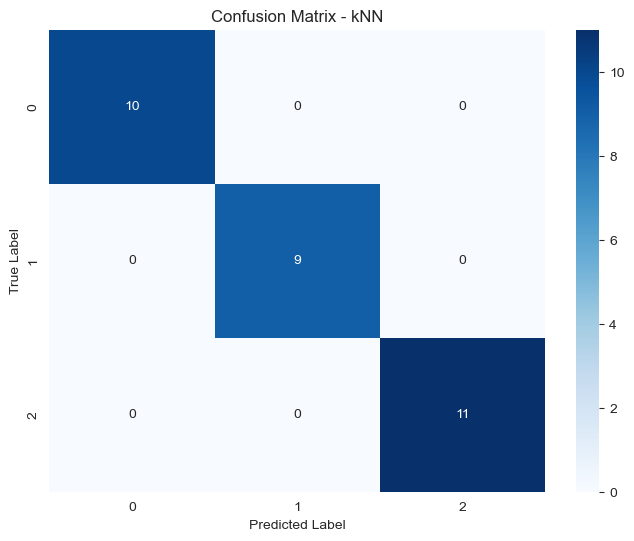

ROC AUC Score and ROC Curve are not applicable for multiclass classification.
Testing kNN on Penguins dataset with k=7, distance_metric=euclidean, weights=distance, p=2
Accuracy: 0.85
Precision: 0.85
Recall: 0.85
F1 Score: 0.85


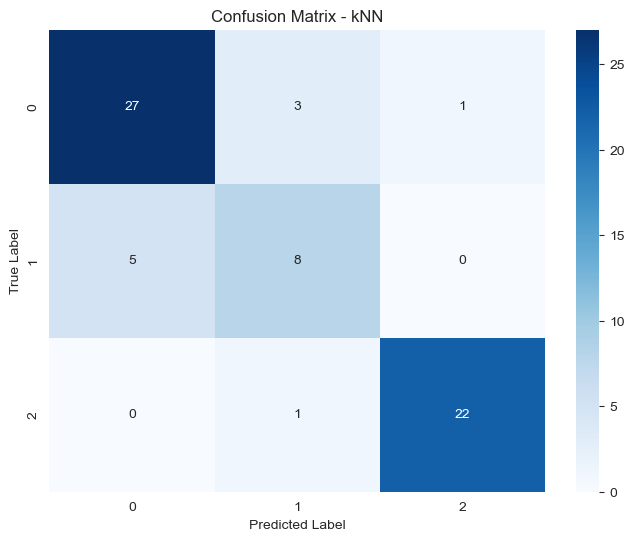

ROC AUC Score and ROC Curve are not applicable for multiclass classification.
Testing kNN on Titanic dataset with k=10, distance_metric=manhattan, weights=distance, p=1
Accuracy: 0.73
Precision: 0.73
Recall: 0.73
F1 Score: 0.73


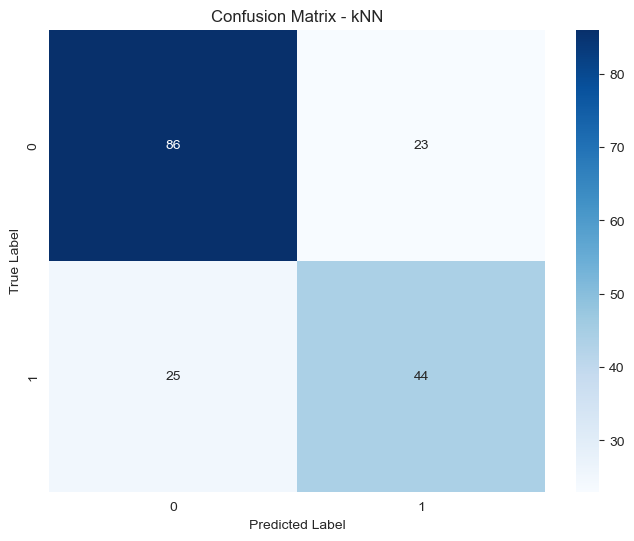

ROC AUC Score: 0.71


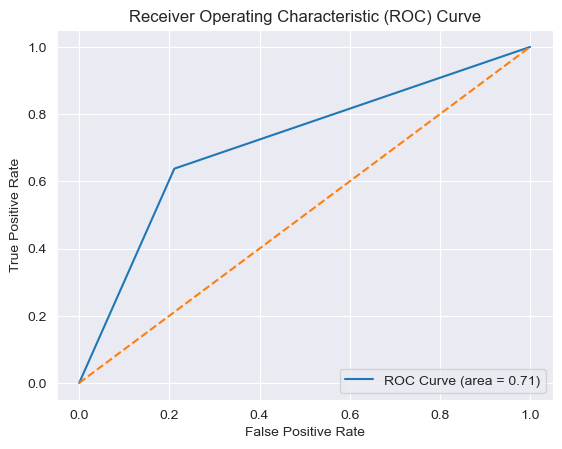

Testing kNN on Census dataset with k=15, distance_metric=minkowski, weights=uniform, p=1.5
Accuracy: 0.80
Precision: 0.80
Recall: 0.80
F1 Score: 0.76


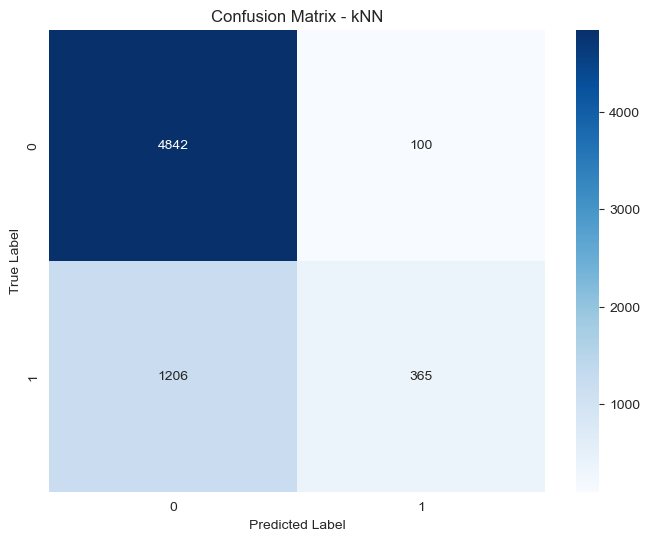

ROC AUC Score: 0.61


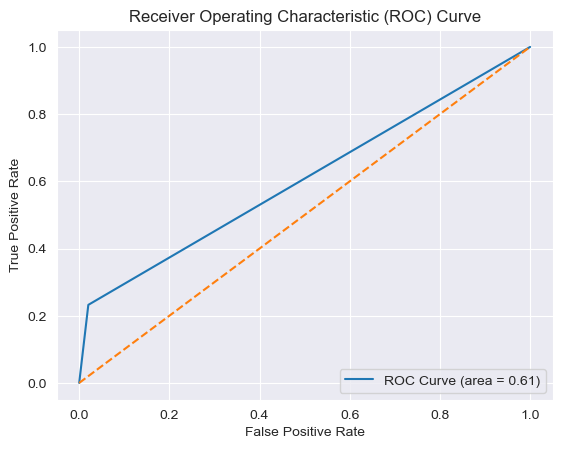

In [42]:
from sklearn.model_selection import train_test_split

datasets = {
    'Iris': {
        'data': (X_iris, y_iris),
        'k': 5,  # A moderate value to balance between overfitting and underfitting. Suitable for a small dataset like Iris.
        'distance_metric': 'euclidean',  # Euclidean distance is appropriate for continuous numeric features that are comparable.
        'weights': 'uniform',  # Uniform weights work well since the dataset is balanced and well-separated.
        'p': 2  # p=2 corresponds to Euclidean distance, which is standard for continuous data.
    },
    'Penguins': {
        'data': (X_penguins, y_penguins),
        'k': 7,  # A slightly larger k to reduce sensitivity to noise in a moderately sized dataset.
        'distance_metric': 'euclidean',  # Suitable for continuous physical measurements, ensuring a natural distance measure.
        'weights': 'distance',  # Closer neighbors are more likely to belong to the same species; weighting by distance improves accuracy.
        'p': 2  # p=2 maintains Euclidean distance for continuous features.
    },
    'Titanic': {
        'data': (X_titanic, y_titanic),
        'k': 10,  # A larger k to provide more stability in the presence of class imbalance and mixed feature types.
        'distance_metric': 'manhattan',  # Manhattan distance is effective for datasets with mixed binary and continuous data.
        'weights': 'distance',  # Distance weighting gives more influence to closer neighbors, which can improve performance on noisy data.
        'p': 1  # p=1 corresponds to Manhattan distance, handling mixed feature types effectively.
    },
    'Census': {
        'data': (X_census, y_census),
        'k': 15,  # A higher k for better generalization in a large dataset with diverse categorical and continuous features.
        'distance_metric': 'minkowski',  # Provides flexibility in handling both types of features by adjusting p.
        'weights': 'uniform',  # Uniform weights help balance the influence of different points in a large, diverse dataset.
        'p': 1.5  # A mixed approach between Manhattan (p=1) and Euclidean (p=2) distances, suitable for varied feature types.
    }
}


for name, params in datasets.items():
    print(f"Testing kNN on {name} dataset with k={params['k']}, distance_metric={params['distance_metric']}, weights={params['weights']}, p={params['p']}")
    
    # Extract data and parameters
    X, y = params['data']
    k = params['k']
    distance_metric = params['distance_metric']
    weights = params['weights']
    p = params['p']
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Evaluate kNN with the specific parameters for the current dataset
    evaluate_knn(X_train, X_test, y_train, y_test, k=k, distance_metric=distance_metric, weights=weights, p=p)